In [50]:
import os, re, time
from dotenv import load_dotenv 
import json
from utils import *
from web3 import Web3
import pandas as pd
from pprint import pprint
from utils import *
from tqdm import tqdm
from decimal import Decimal
from datetime import datetime
import numpy as np
import mplfinance as mpf

# Get the config file
configObj = ConfigManager("config.json")
appInfo, configData = configObj.load_config()
nodeUrl = appInfo["alchemy_url"]+appInfo["alchemy_key"]


Downloaded 628 trades from trades block 21561008 to 21601008 (40000 remaining). 
Download finished. Aggregating 628 trades ...
627 block timestamps were not found in the provided files. Downloading them manually. This might take some time...


100%|██████████| 627/627 [02:41<00:00,  3.89it/s]


ValueError: zero-size array to reduction operation maximum which has no identity

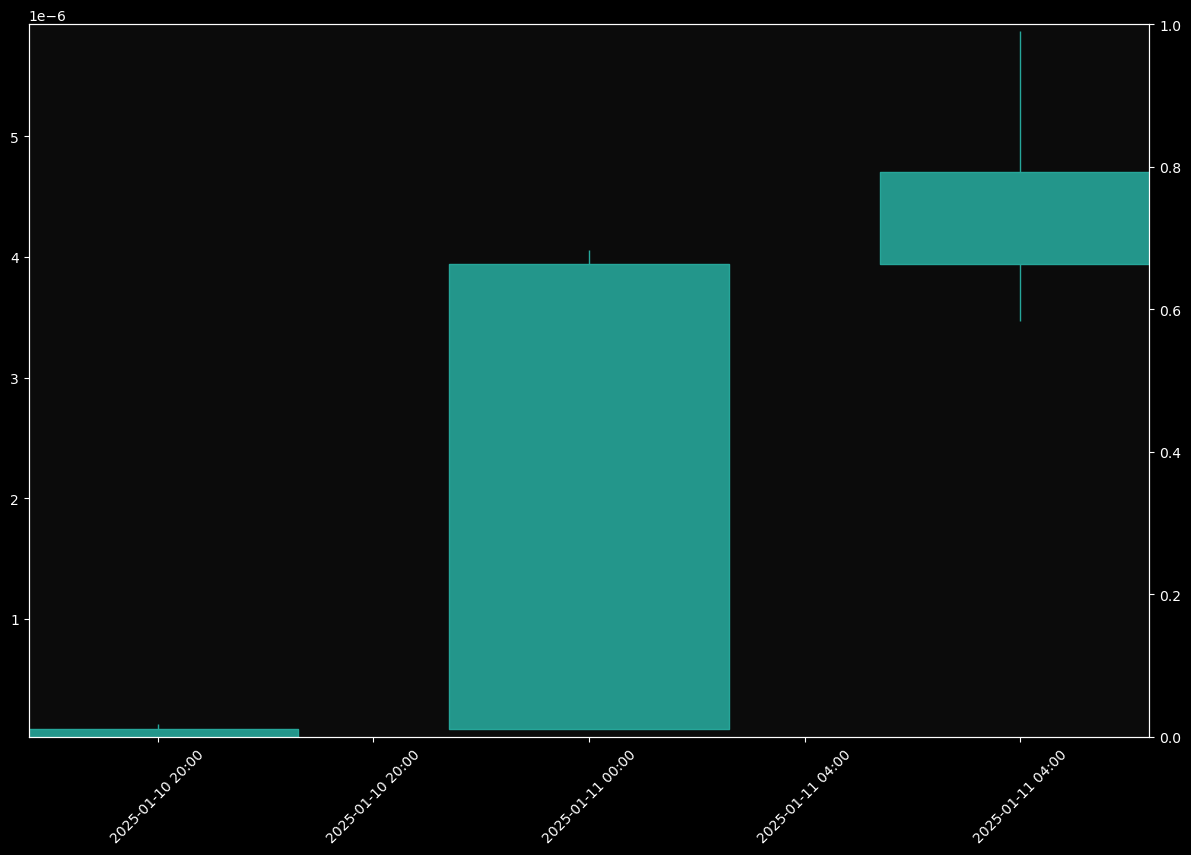

In [ ]:
class tokenCandlestick:
    
    def __init__(self, path:str, web3:Web3, verbose:bool = False):
        """
        Initiates the class.
        
        Args:
            path: The path to search for *.csv files.Each file name should have the 
                following pattern: {startBlockNumber}-{endBlockNumber}.csv
                Each row should have 3 columns. Namely, block, timestamp and datetime.
            web3 (Web3): A web3 object to interact with blockchain.
            verbose (bool): Weather the app should describe what its doing ot user.
        """
        
        # Get available block-timestamp pairs
        # Get all files and sort them
        # List to store the results
        availableBlocks = []
        
        # Get all files in the directory and add it to a dataframe
        try:
            files = os.listdir(path)
            
            # Process each file
            for filename in files:
                # Check if it's a CSV file
                if filename.endswith('.csv'):
                    # Use regex to find numbers separated by dash
                    matches = re.findall(r'(\d+)-(\d+)', filename)
                    
                    # If we found a match, convert strings to integers and add to our list
                    if matches:
                        # Take the first match (in case there are multiple)
                        x, y = matches[0]
                        availableBlocks.append({"start":int(x), "finish":int(y)})
        
        except FileNotFoundError:
            print(f"Directory not found: {path}")
            return []
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            return []
        
        # Set params
        self.availableBlocks = pd.DataFrame(availableBlocks).sort_values("start")      
        
        with open("./resources/ABIs/UNI_V2_SWAP_EVENT.abi", 'r') as abi_file:
            abi_content = abi_file.read()
            self.UNI_V2_SWAP_EVENT_ABI = json.loads(abi_content)
        with open("./resources/ABIs/UNI_V3_SWAP_EVENT.abi", 'r') as abi_file:
            abi_content = abi_file.read()
            self.UNI_V3_SWAP_EVENT_ABI = json.loads(abi_content)
        
        self.web3 = web3
        self.verbose = verbose

    def get_plot(self, df:pd.DataFrame, tf:str, info = None):
        """
        Plots the asset using matplotlib finance
        
        Args:
            df (pd.Dataframe): A dataframe containing price and time of the trade. Time
            of the trade should be in datetime and should be as the index of the 
            dataframe
            tf (str): The timeframe to aggregate the data for. (e.g. 1min, 1h, 1d, etc.) 
            info (dict): Info about the chart. Acceptable keys: {title, } 
        """
        
        ohlc = df["price"].resample(tf)

        ohlc = pd.DataFrame({
            'open': ohlc.first(),
            'high': np.maximum(ohlc.max(),ohlc.first().shift(-1)),
            'low': np.minimum(ohlc.min(),ohlc.first().shift(-1)),
            'close': ohlc.first().shift(-1)  # First price of next period
        }).dropna()

        # Plot an SMA20
        sma = ohlc['close'].rolling(window=20).mean()
        apds = [
            mpf.make_addplot(sma, color='orange', width=0.8) if 0 < sma.shape[0] else None
            ]
        apds = list(filter(None, apds))
        
        # Custom style
        mc = mpf.make_marketcolors(
            up='#26a69a',      # Green candle
            down='#ef5350',    # Red candle
            edge='inherit',    # Inherit the same color for edges
            wick='inherit',    # Inherit the same color for wicks
            volume='in',       # Volume bars use same colors as candles
            ohlc='inherit'     # OHLC bars use same colors
        )

        # Create a custom style
        style = mpf.make_mpf_style(
            marketcolors=mc,
            gridstyle='',          # Remove grid
            y_on_right=True,       # Price axis on the right
            rc={'font.size': 10},  # Base font size
            base_mpf_style='nightclouds'  # Base on the nightclouds style
        )

        # Plot with more customization
        mpf.plot(ohlc, 
                type='candle',
                title= info["title"] if info != None else 'Price Chart',
                style=style,
                volume=False,
                figsize=(12, 8),      # Larger figure size
                tight_layout=True,     # Tight layout
                ylabel='Price',    
                addplot=apds,    
                datetime_format='%Y-%m-%d %H:%M',  # Date format
                scale_padding={'left': 0.5, 'right': 0.5, 'top': 0.8, 'bottom': 0.8})  # Add some padding

    def process_transactions(self, transactions):
        """
        Process the raw transactions to a pandas dataframe. While block numbers are
        returned when downloading the trades from blockchain, these trades only contain 
        block number, and their timestamps are not denoted. To get each trade's 
        timestamp we should have a pair of each block's timestamp (which we take when
        making the object). After iterating through it, we take time stamp of each 
        required block number and add it to a new column. 
        
        Args:
            transactions (list): A list of trades, containing at leas two columns
        
        Returns:
            A dataframe containing price of each trade, and its time (in datetime and 
            as index)
        """
        df = pd.DataFrame(transactions)
        df['timestamp'] = None
        
        # Get timestamp for each trade using its block number
        for idx, row in candleHandler.availableBlocks.iterrows():
            __df = pd.read_csv(f"./resources/ETH_block_data/{row[0]}-{row[1]}.csv")
            __df = __df[__df["block"].isin(df.block_number)]
            
            if __df.shape[0] != 0:
                # Update df1's target_column based on matching ids
                df["timestamp"] = df["timestamp"].combine_first(df['block_number'].map(
                    __df.set_index('block')['timestamp']
                ))

        # If there are any missing block timestamps, find them
        __df = df[df["timestamp"].isna()]
        print(f"{__df.shape[0]} block timestamps were not found in the provided files. Downloading them manually. This might take some time...")
        for idx, row in tqdm(__df.iterrows(), total = __df.shape[0]):
            df.loc[idx,"timestamp"] = web3Obj.eth.get_block(row["block_number"])["timestamp"]

        # Make timestamp in milliseconds. Cast price to float as well
        df["timestamp"] = (df["timestamp"] * 1000).astype(np.int64)
        df["price"] = df["price"].astype(float)
        
        # Take two columns (price and timestamp). Change timestamp to datetime and set it as index.
        df = df[["price","timestamp"]]
        df["datetime"] = pd.to_datetime(df["timestamp"],unit="ms")
        df = df.set_index("datetime", drop = True)
        
        return df

    def get_uniswap_pair_transactions(
        self, 
        pair_address: str, 
        from_block: int, 
        to_block: int, 
        step: int, 
        token0_decimals: int, 
        token1_decimals: int, 
        quote_token: int, 
        pref_token: int = None,
        min_tx_volume: float = None) -> List[dict]:
        
        """
        Fetches and processes swap events from a DEX pair contract.
        If the RPC node failed to send us the swap info (due to high size), it
        halves the block range (repeats 10 times) until a valid response is 
        received. 

        Args:
            pair_address (str): Address of the pair contract
            from_block (int): Starting block number
            to_block (int): Ending block number 
            step (int): The step size when searching iteratively, starting from "from_block"
                Set "None" to avoid dividing teh block range.
            token0_decimals (int): Decimal points ofr token 0.
            token2_decimals (int): Decimal points ofr token 2.
            quote_token (int): The version of uniswap pool. Required for choosing correct ABI.
                acceptable values: 2 or 3
            pref_token (int): Preferred token to calculate price and volume related to them. 
                Only 0, 1 and None are acceptable. If None passed, we have no preference and
                return the price of selling (Token 0 sold for token 1 or vice versa)
            min_tx_volume (float): Minimum transaction volume. The values below it will be 
                disregarded. Set None for disregarding this filter. The size will be calculated 
                in "pref_token". So for using this filter, you should pass this parameter as well.

        Returns:
            A list containing trades.
        
        Dependencies:
            - Web3.py
            - PAIR_ABI constant
        """
        # Check the requirements
        if quote_token not in [2, 3]:
            raise Exception("Pool version should be an integer. 2 or 3 are acceptable for now.")
        
        if pref_token not in [0, 1, None]:
            raise Exception("Preferred token can only be 0 or 1. Pass None if you have no preference")
        
        if pref_token == None and min_tx_volume != None:
            raise Exception("Minimum token volume will be calculated in pref_token. So you have to pass it as well")
            
        # Initialize web3 object
        w3 = self.web3
        
        # Create contract instance
        pair_address = Web3.to_checksum_address(pair_address)
        pair_contract = w3.eth.contract(
            address=pair_address, 
            abi = self.UNI_V2_SWAP_EVENT_ABI if quote_token == 2 else self.UNI_V3_SWAP_EVENT_ABI if quote_token == 3 else None)
        
        # If step is None, try to get the entire block range in one go
        if step == None:
            step = to_block - from_block
        
        # A list to save swap events
        swap_events = []
        
        # Loop params
        i = from_block
        counter = 0 # For every acceptable response increases by one. Goes back to zero when faced big size error in alchemy.
        __Stop = False # For stopping the loop
        
        # Get all swap events
        while i <= to_block and not __Stop:
            try:
                # Double the step if four previous steps were successful
                if counter == 3:
                    counter = 0
                    step = step * 2
                    if self.verbose: print(f"++ Doubled the step size to {step}")
                
                # Set the start and end of current block batch to download
                __from = i
                __to = i + step if i + step <= to_block else to_block
                
                # Break, if start and end of the block range is the same
                if __from == __to: break
                
                tmp = pair_contract.events.Swap.get_logs(
                    from_block = __from,
                    to_block = __to
                )
                swap_events += tmp
                counter += 1
                
                if self.verbose: print(f"Downloaded {len(tmp)} trades from trades block {__from} to {__to} ({to_block - __from} remaining). ")
                
                __Stop = True if i == to_block else False
                i = i + step if i + step <= to_block else to_block
                
            except Exception as e:
                # Try 10 times, each time half the step size to see what works
                for j in range(1,10):
                    try:
                        counter = 0
                        _step = int(step / (2 ** j))
                        if self.verbose: print(f"-- Halved each step to {_step}")
                        
                        __from = i
                        __to = i + _step if i + _step <= to_block else to_block
                        tmp = pair_contract.events.Swap.get_logs(
                            from_block = __from,
                            to_block = __to
                        )
                        swap_events += tmp
                        
                        if self.verbose: print(f"Downloaded {len(tmp)} trades from trades block {__from} to {__to} ({to_block - __from} remaining).")
                        
                        # If no errors found, update the step and go to previous searching scheme
                        step = _step
                        __Stop = True if i == to_block else False
                        i = i + step if i + step <= to_block else to_block
                        break
                    except Exception as e:
                        _errorText = str(e)
                        __Stop = True
                
                # Exit getting the transactions
                if j == 9:
                    raise Exception(f"Facing errors. Halved the steps until {_step} but still getting the following error:\n\n {_errorText}")
                
            time.sleep(.1)
            
        transactions = []
        
        if self.verbose: print(f"Download finished. Aggregating {len(swap_events)} trades ...")
        
        # Process each swap event
        for event in swap_events:
            if quote_token == 2:
                # Only for uniswap V2 transactions
                amount0_in = Decimal(event['args']['amount0In']) / Decimal(10 ** token0_decimals)
                amount1_in = Decimal(event['args']['amount1In']) / Decimal(10 ** token1_decimals)
                amount0_out = Decimal(event['args']['amount0Out']) / Decimal(10 ** token0_decimals)
                amount1_out = Decimal(event['args']['amount1Out']) / Decimal(10 ** token1_decimals)
                
                # Calculate effective amounts
                amount0_delta = amount0_in - amount0_out
                amount1_delta = amount1_in - amount1_out
                
                # Calculate price and volume
                if pref_token == None:
                    if amount0_delta > 0:  # Selling token0 for token1
                        price = abs(amount1_delta / amount0_delta)
                        volume = abs(amount0_delta)  # Assuming token1 is USD or stable
                    else:  # Selling token1 for token0
                        price = abs(amount0_delta / amount1_delta)
                        volume = abs(amount1_delta)  # Assuming token1 is USD or stable
                elif pref_token == 0:
                    price = abs(amount0_delta / amount1_delta)
                    volume = abs(amount0_delta)
                elif pref_token == 1:
                    price = abs(amount1_delta / amount0_delta)
                    volume = abs(amount1_delta)
                
                # Filter minimum transaction values
                if min_tx_volume != None:
                    if volume < min_tx_volume:
                        continue
                
                tx = {
                    'transaction_hash': event['transactionHash'].hex(),
                    'block_number': event['blockNumber'],
                    'sender': event['args']['sender'],
                    'recipient': event['args']['to'],
                    'price': price,
                    'volume': volume
                }
                
                transactions.append(tx)
            elif quote_token == 3:
                # Only for uniswap V3 transactions
                # # For uniswap V3, each transaction also contains the following info, however, we disregard them
                # # price_from_sqrt, amounts0, amount1, tick, liquidity which are calculated below:
                # sqrt_price_x96 = Decimal(event['args']['sqrtPriceX96'])
                # price_from_sqrt = (sqrt_price_x96 / Decimal(2**96)) ** 2
                
                # Get amounts (note: V3 uses signed integers)
                amount0 = Decimal(event['args']['amount0']) / Decimal(10 ** token0_decimals)
                amount1 = Decimal(event['args']['amount1']) / Decimal(10 ** token1_decimals)

                # Get price from sqrtPriceX96

                if pref_token == None:
                    # Determine which token was sold
                    if amount0 > 0:  # Positive means token was received by the pool (sold by user)
                        # Token0 was sold for Token1
                        sold_amount = amount0
                        bought_amount = -amount1  # Negative because it was received by user
                        # token_path = "0->1"
                        price = abs(amount1 / amount0) if amount0 != 0 else 0
                    else:
                        # Token1 was sold for Token0
                        sold_amount = amount1
                        bought_amount = -amount0  # Negative because it was received by user
                        # token_path = "1->0"
                        price = abs(amount0 / amount1) if amount1 != 0 else 0

                    # Calculate volume in terms of sold token
                    volume = float(abs(sold_amount))
                elif pref_token == 0:
                    price = abs(amount0 / amount1)
                    volume = abs(amount0)
                elif pref_token == 1:
                    price = abs(amount1 / amount0)
                    volume = abs(amount1)
                
                tx = {
                    'transaction_hash': event['transactionHash'].hex(),
                    'block_number': event['blockNumber'],
                    'sender': event['args']['sender'],
                    'recipient': event['args']['recipient'],
                    "price": str(price),
                    "volume": volume,
                }  
                
                transactions.append(tx)                
            
        return transactions


# Replace these values with your specific pair
PAIR_ADDRESS = "0x4ea0205669bcd30144f98170090163e42609870e"; "0x9C4CC862F51B1Ba90485De3502AA058CA4331F32"
RPC_URL = nodeUrl
web3Obj = Web3(Web3.HTTPProvider(nodeUrl))

# Get transactions from the last 1000 blocks
end_block = 21400000 + 80000
from_block = 21400000 - 60000
end_block = web3Obj.eth.block_number
from_block = end_block - 40000

handler = ETH_Handler(web3Obj)
pairInfo = handler.get_pair_info(PAIR_ADDRESS)
quoteAssetIndex = 0 if pairInfo["token0"]["symbol"] == "WETH" else 1 if pairInfo["token1"]["symbol"] == "WETH" else None
quoteAsset = pairInfo[f"token{quoteAssetIndex}"]["symbol"]
baseAsset = pairInfo[f"token{quoteAssetIndex-1 if quoteAssetIndex == 1 else 1}"]["symbol"]
assetName = f"{baseAsset}/{quoteAsset}"

candleHandler = tokenCandlestick("./resources/ETH_block_data", web3Obj, True)
transactions = candleHandler.get_uniswap_pair_transactions(
    PAIR_ADDRESS, 
    from_block, 
    end_block, 
    None, 
    pairInfo["token0"]["decimals"], 
    pairInfo["token1"]["decimals"], 
    2 if pairInfo["version"]=="UNI_V2" else 3 if pairInfo["version"]=="UNI_V3" else -1,
    quoteAssetIndex,
    0.0001)
priceDf = candleHandler.process_transactions(transactions)
candleHandler.get_plot(priceDf, "4h", {"title":assetName})

In [115]:

ohlc = priceDf["price"].resample("15min")

# for group_name, group_df in ohlc:
#     print(f"Group: {group_name}")
#     print(group_df)

np.minimum(ohlc.first(),ohlc.first())

datetime
2025-01-10 20:45:00    1.207644e-08
2025-01-10 21:00:00    6.743077e-07
2025-01-10 21:15:00    1.018430e-06
2025-01-10 21:30:00    1.745073e-06
2025-01-10 21:45:00    2.706242e-06
2025-01-10 22:00:00    2.710517e-06
2025-01-10 22:15:00    1.958470e-06
2025-01-10 22:30:00    2.479285e-06
2025-01-10 22:45:00    2.421999e-06
2025-01-10 23:00:00    2.290083e-06
2025-01-10 23:15:00    2.123493e-06
2025-01-10 23:30:00    2.291509e-06
2025-01-10 23:45:00    2.534396e-06
2025-01-11 00:00:00    2.446854e-06
2025-01-11 00:15:00    2.234964e-06
2025-01-11 00:30:00    1.320085e-06
2025-01-11 00:45:00    1.330755e-06
2025-01-11 01:00:00             NaN
2025-01-11 01:15:00    1.722823e-06
2025-01-11 01:30:00    1.768132e-06
2025-01-11 01:45:00    1.479368e-06
2025-01-11 02:00:00    1.371282e-06
2025-01-11 02:15:00             NaN
2025-01-11 02:30:00    1.364685e-06
2025-01-11 02:45:00    1.434766e-06
2025-01-11 03:00:00    1.472818e-06
2025-01-11 03:15:00    1.546489e-06
2025-01-11 03:30:00

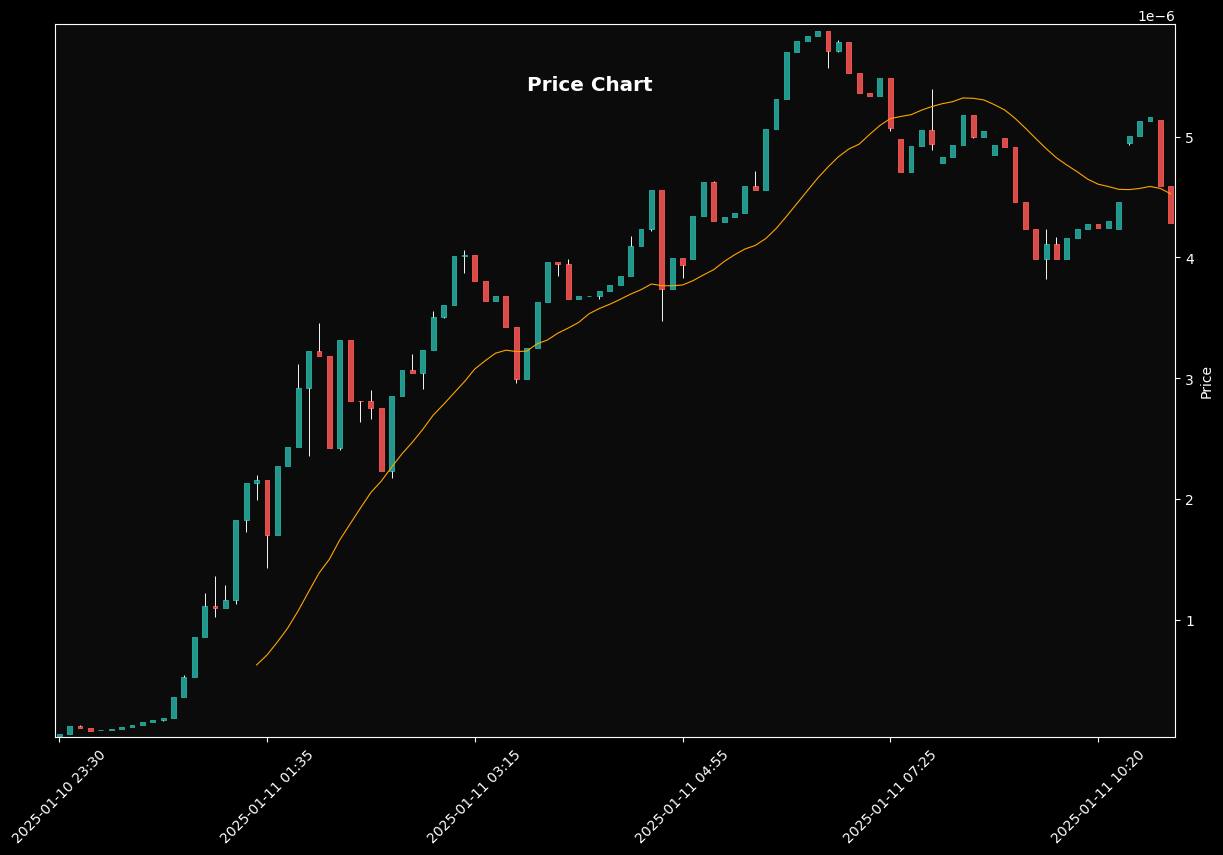

In [134]:
"""
Plots the asset using matplotlib finance

Args:
    df (pd.Dataframe): A dataframe containing price and time of the trade. Time
    of the trade should be in datetime and should be as the index of the 
    dataframe
    tf (str): The timeframe to aggregate the data for. (e.g. 1min, 1h, 1d, etc.) 
    info (dict): Info about the chart. Acceptable keys: {title, } 
"""

ohlc = priceDf["price"].resample("5min")

ohlc = pd.DataFrame({
    'open': ohlc.first(),
    'high': np.maximum(ohlc.max(),ohlc.first().shift(-1)),
    'low': np.minimum(ohlc.min(),ohlc.first().shift(-1)),
    'close': ohlc.first().shift(-1)  # First price of next period
}).dropna()

# Plot an SMA20
sma = ohlc['close'].rolling(window=20).mean()
apds = [
    mpf.make_addplot(sma, color='orange', width=0.8) if 0 < sma.shape[0] else None
    ]
apds = list(filter(None, apds))

# Custom style
mc = mpf.make_marketcolors(
    up='#26a69a',      # Green candle
    down='#ef5350',    # Red candle
    edge='inherit',    # Inherit the same color for edges
    wick='#ffffff',    # Inherit the same color for wicks
    volume='in',       # Volume bars use same colors as candles
    ohlc='inherit'     # OHLC bars use same colors
)

# Create a custom style
style = mpf.make_mpf_style(
    marketcolors=mc,
    gridstyle='',          # Remove grid
    y_on_right=True,       # Price axis on the right
    rc={'font.size': 10},  # Base font size
    base_mpf_style='nightclouds'  # Base on the nightclouds style
)

# Plot with more customization
mpf.plot(ohlc, 
        type='candle',
        title= 'Price Chart',
        style=style,
        volume=False,
        figsize=(12, 8),      # Larger figure size
        tight_layout=True,     # Tight layout
        ylabel='Price',    
        addplot=apds,    
        datetime_format='%Y-%m-%d %H:%M',  # Date format
        scale_padding={'left': 0.5, 'right': 0.5, 'top': 0.8, 'bottom': 0.8})  # Add some padding